In [1]:
import pandas as pd
import tensorflow as tf
import sys
print(sys.version)
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import scipy
from ipywidgets import interact, widgets
from scipy import stats
import seaborn as sns
import os
import json
from pprint import pprint
import cv2

3.7.7 (default, Mar 10 2020, 15:43:33) 
[Clang 11.0.0 (clang-1100.0.33.17)]


Using TensorFlow backend.


In [51]:
import torch
import torch.nnb
from models.resnet import InsResNet50

In [53]:
model = InsResNet50()


InsResNet50(
  (encoder): DataParallel(
    (module): ResNet(
      (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(

In [30]:
numGrids = 12
features = []
y = []
count = 0
for file in os.listdir("./imageLabel/."):
    if(file.startswith("A")):
        #file = "A (101)"
        print("Extracting labels from file " + file)
        data = json.loads(open('imageLabel/' + file + "/data_file.json").read())
        imgPath = "./imagesDataset/" + file + ".jpg"
        if os.path.isfile(imgPath) and 'labels' in data:
            img = cv2.imread("imagesDataset/" + file + ".jpg")
            height, width, channels = img.shape
            gheight, gwidth = int(height/numGrids) , int(width/numGrids)
            for index, gridLabel in enumerate(data['labels']):
                if gridLabel:
                    colIndex = index % numGrids
                    rowIndex = int(index / numGrids)
                    grid = img[rowIndex * gheight : (rowIndex + 1) * gheight, colIndex * gwidth : (colIndex + 1) * gwidth, :]
                    blur = cv2.resize(img, (256, 256))
                    
                    #feature extraction
                    featureList = []
                    gridRed = grid[:,:,0]
                    gridGreen = grid[:,:,1]
                    gridBlue = grid[:,:,2]
                    rbar = np.average(gridRed)
                    gbar = np.average(gridGreen)
                    bbar = np.average(gridBlue)
                    featureList.append(rbar)
                    featureList.append(gbar)
                    featureList.append(bbar)
                    featureList += np.bincount(np.ravel((gridRed/32).astype(int)), minlength = 8).tolist()
                    featureList += np.bincount(np.ravel((gridGreen/32).astype(int)), minlength = 8).tolist()
                    featureList += np.bincount(np.ravel((gridBlue/32).astype(int)), minlength = 8).tolist()
                    width, height, dimension = grid.shape
                    f = np.fft.fft2(grid)
                    fshift = np.fft.fftshift(f)
                    magnitude_spectrum = np.abs(20*np.log(np.abs(fshift + 0.00001)))
                    featureList += np.average(np.average(magnitude_spectrum,axis = 0), axis = 0).tolist()
                    featureList += [index]
                    features.append(featureList)
                    y.append(gridLabel)
#     count += 1
#     if(count == 1):
#         break
                    
features = np.asarray(features)
#features = features / features.max(axis=0)
print("Features shape", features.shape, " label shape", len(y))  

Extracting labels from file A (108)
Extracting labels from file A (141)
Extracting labels from file A (243)
Extracting labels from file A (187)
Extracting labels from file A (225)
Extracting labels from file A (30)
Extracting labels from file A (127)
Extracting labels from file A (164)
Extracting labels from file A (15)
Extracting labels from file A (249)
Extracting labels from file A (200)
Extracting labels from file A (102)
Extracting labels from file A (209)
Extracting labels from file A (240)
Extracting labels from file A (184)
Extracting labels from file A (142)
Extracting labels from file A (124)
Extracting labels from file A (9)
Extracting labels from file A (226)
Extracting labels from file A (33)
Extracting labels from file A (39)
Extracting labels from file A (3)
Extracting labels from file A (167)
Extracting labels from file A (148)
Extracting labels from file A (101)
Extracting labels from file A (16)
Extracting labels from file A (203)
Extracting labels from file A (237)
E

In [83]:
numGrids = 12
y = []
for file in os.listdir("./imageLabel/."):
    if(file.startswith("A")):
        data = json.loads(open('imageLabel/' + file + "/data_file.json").read())
        imgPath = "./imagesDataset/" + file + ".jpg"
        if os.path.isfile(imgPath) and 'labels' in data:
            for index, gridLabel in enumerate(data['labels']):
                if gridLabel:
                    y.append([f'{file}.jpg%{index}', gridLabel])

df = pd.DataFrame(y, columns=['Image', 'label'])

print(df)  
cnt = collections.Counter(df.label)
rareClasses = set([k for k, v in cnt.items() if v<100])
for cls in rareClasses:
    df = df[df.label != cls]
df = df.join(df.label.str.get_dummies())
df.to_csv(r'train.csv')

                Image  label
0      A (141).jpg%63  Other
1      A (141).jpg%64  Other
2      A (141).jpg%65  Other
3      A (141).jpg%66  Other
4      A (141).jpg%74  Other
...               ...    ...
7206  A (103).jpg%135   Wood
7207  A (103).jpg%136   Wood
7208  A (103).jpg%137   Wood
7209  A (103).jpg%138   Wood
7210  A (103).jpg%139   Wood

[7211 rows x 2 columns]


In [84]:
from PIL import Image
import numpy as np

numGrids = 12
features = []
y = []
count = 0
for file in os.listdir("./imageLabel/."):
    if(file.startswith("A")):
        print("Making photos from file " + file)
        data = json.loads(open('imageLabel/' + file + "/data_file.json").read())
        imgPath = "./imagesDataset/" + file + ".jpg"
        if os.path.isfile(imgPath) and 'labels' in data:
            img = cv2.imread("imagesDataset/" + file + ".jpg")
            height, width, channels = img.shape
            gheight, gwidth = int(height/numGrids) , int(width/numGrids)
            for index, gridLabel in enumerate(data['labels']):
                if gridLabel:
                    colIndex = index % numGrids
                    rowIndex = int(index / numGrids)
                    grid = img[rowIndex * gheight : (rowIndex + 1) * gheight, colIndex * gwidth : (colIndex + 1) * gwidth, :]
                    data = grid
                    #Rescale to 0-255 and convert to uint8
                    rescaled = (255.0 / data.max() * (data - data.min())).astype(np.uint8)

                    im = Image.fromarray(rescaled)
                    im.save(f'./data/{file[3:-1]}_{index}.jpg')

Making photos from file A (108)
Making photos from file A (141)
Making photos from file A (243)
Making photos from file A (187)
Making photos from file A (225)
Making photos from file A (30)
Making photos from file A (127)
Making photos from file A (164)
Making photos from file A (15)
Making photos from file A (249)
Making photos from file A (200)
Making photos from file A (102)
Making photos from file A (209)
Making photos from file A (240)
Making photos from file A (184)
Making photos from file A (142)
Making photos from file A (124)
Making photos from file A (9)
Making photos from file A (226)
Making photos from file A (33)
Making photos from file A (39)
Making photos from file A (3)
Making photos from file A (167)
Making photos from file A (148)
Making photos from file A (101)
Making photos from file A (16)
Making photos from file A (203)
Making photos from file A (237)
Making photos from file A (22)
Making photos from file A (135)
Making photos from file A (153)
Making photos from

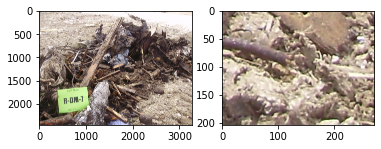

In [37]:
def drawGrid(picNum, index):
    img = cv2.imread("./imagesDataset/" + "A ("+ str(picNum) +")" + ".jpg")
    colIndex = index % numGrids
    rowIndex = int(index / numGrids)
    grid = img[rowIndex * gheight : (rowIndex + 1) * gheight, colIndex * gwidth : (colIndex + 1) * gwidth]
    plt.subplot(121),plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(122),plt.imshow(cv2.cvtColor(grid, cv2.COLOR_BGR2RGB))
    
drawGrid(100, 141)

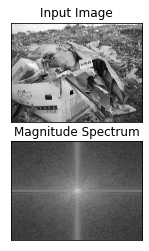

In [40]:
sns.reset_orig()
img = cv2.imread("./imagesDataset/" + "A (254)" + ".jpg", 0)
grid = img[rowIndex * gheight : (rowIndex + 1) * gheight, colIndex * gwidth : (colIndex + 1) * gwidth]
rowIndex = index % numGrids
colIndex = int(index / numGrids)
width, height = grid.shape
f = np.fft.fft2(grid)
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.abs(20*np.log(np.abs(fshift)))



plt.subplot(211),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(212),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.savefig('./img/dft.png')

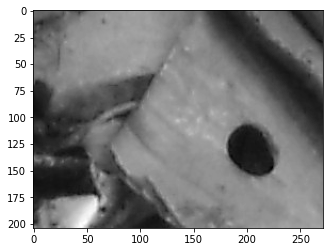

In [41]:
plt.imshow(grid, cmap = 'gray')


In [42]:
width, height = grid.shape
f = np.fft.fft2(grid/256.)
fshift = np.fft.fftshift(f)
magnitude_spectrum = np.abs(20*np.log(np.abs(fshift)))
np.average(np.average(magnitude_spectrum,axis = 0), axis = 0)


21.476313875932487

In [43]:
#normalize all data
features = features / features.max(axis=0)

In [44]:
jobs = list(set(y))
counts = [y.count(job) for job in jobs]
print(jobs)
print(counts)

['Wood', 'Plastic', 'Other', 'Bricks', 'Gypsum', 'Metal', 'Organics', 'Roofing', 'Concrete']
[4151, 713, 464, 6, 266, 252, 4, 1050, 305]


In [50]:
4151/len(y)

0.5756483150741922

Text(0.5, 1.0, 'Number of Labels for Each Waste Type')

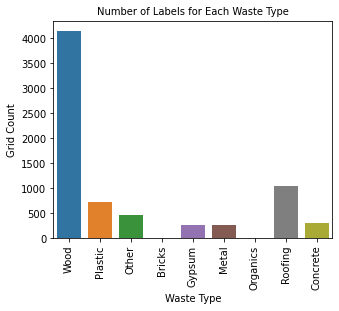

In [45]:
f, ax = plt.subplots(figsize=(5, 4))
plt.xticks(rotation='90')
sns.barplot(x=jobs, y=counts)
plt.xlabel('Waste Type', fontsize=10)
plt.ylabel('Grid Count', fontsize=10)
plt.title('Number of Labels for Each Waste Type', fontsize=10)

In [14]:
stringDic = {}
for i in range(len(jobs)):
    stringDic[jobs[i]] = i

if isinstance(y, list):
    for i in range (len(y)):
        if(y[i] in stringDic):
            y[i] = stringDic[y[i]]
print("Features shape", features.shape, " label shape", len(y))

Features shape (10167, 31)  label shape 10167


In [15]:
reverseDic = {v: k for k, v in stringDic.items()}

import pickle

pickle_out = open("dict.pickle","wb")
pickle.dump(reverseDic, pickle_out)
pickle_out.close()

Feature Extracting Themes
1. Input Vector: RGB-bar (3)
2. RGB-frequencies into 8 factors histograms (8 * 3)
3. 256 gradient map (8 * 3)
4. Hue, Saturation, Lightness

average 0.6829252358550749 variance 0.003495258746258725


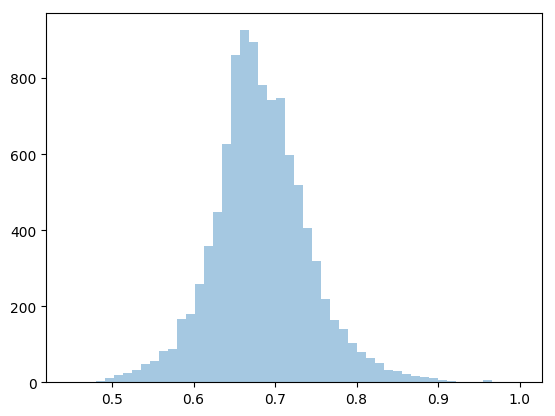

In [16]:
import seaborn as sns
colorIndex = 29
print("average", np.average(features[:,colorIndex]), "variance", np.var(features[:,colorIndex]))
sns.distplot(features[:,colorIndex],kde=False)

In [17]:
from sklearn.model_selection import train_test_split

# split dataset into 80% training data points and 20% testing data points

train_Y_one_hot = to_categorical(y)
train_X,test_X,train_label,test_label = train_test_split(features, train_Y_one_hot, test_size=0.2, random_state=12)

print('Training data shape : ', train_X.shape, train_label.shape, 'Testing data shape: ', test_X.shape, test_label.shape)

Training data shape :  (8133, 31) (8133, 9) Testing data shape:  (2034, 31) (2034, 9)


In [18]:
# identify the number of classes and 

classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', jobs)

Total number of outputs :  9
Output classes :  ['Other', 'Plastic', 'Roofing', 'Organics', 'Wood', 'Bricks', 'Concrete', 'Gypsum', 'Metal']


In [19]:
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_label, test_size=0.2, random_state=13)
print('Training data shape : ', train_X.shape, train_label.shape, 'Validing data shape: ', valid_X.shape, valid_label.shape)

Training data shape :  (6506, 31) (6506, 9) Validing data shape:  (1627, 31) (1627, 9)


In [24]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from sklearn.preprocessing import normalize

In [ ]:
import torch
import torch.nn
from models.resnet import resnet

In [25]:
batch_size = 64
epochs = 200
num_classes = nClasses

model = keras.Sequential([
    keras.layers.Dense(16, input_shape=(features.shape[1],)),
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(32, activation=tf.nn.relu),
    keras.layers.Dense(nClasses, activation=tf.nn.softmax)
])

In [26]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                512       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 297       
Total params: 1,625
Trainable params: 1,625
Non-trainable params: 0
_________________________________________________________________


In [29]:
# tf.contrib.training.HParams(learning_rate=0.1, num_hidden_units=100)
result = model.fit(features, train_Y_one_hot, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 10167 samples, validate on 1627 samples
Epoch 1/200
10167/10167 [==============================] - 1s 85us/step - loss: 1.5506 - acc: 0.5102 - val_loss: 1.3218 - val_acc: 0.5943
Epoch 2/200
10167/10167 [==============================] - 0s 24us/step - loss: 1.2597 - acc: 0.6209 - val_loss: 1.1864 - val_acc: 0.6447
Epoch 3/200
10167/10167 [==============================] - 0s 25us/step - loss: 1.1581 - acc: 0.6524 - val_loss: 1.1214 - val_acc: 0.6564
Epoch 4/200
10167/10167 [==============================] - 0s 25us/step - loss: 1.1056 - acc: 0.6626 - val_loss: 1.0828 - val_acc: 0.6669
Epoch 5/200
10167/10167 [==============================] - 0s 23us/step - loss: 1.0830 - acc: 0.6675 - val_loss: 1.0671 - val_acc: 0.6675
Epoch 6/200
10167/10167 [==============================] - 0s 23us/step - loss: 1.0698 - acc: 0.6697 - val_loss: 1.0641 - val_acc: 0.6656
Epoch 7/200
10167/10167 [==============================] - 0s 26us/step - loss: 1.0576 - acc: 0.6736 - val_loss: 1.0450 - v

Epoch 118/200
10167/10167 [==============================] - 0s 23us/step - loss: 0.8413 - acc: 0.7153 - val_loss: 0.8215 - val_acc: 0.7271
Epoch 119/200
10167/10167 [==============================] - 0s 21us/step - loss: 0.8382 - acc: 0.7170 - val_loss: 0.8337 - val_acc: 0.7179
Epoch 120/200
10167/10167 [==============================] - 0s 21us/step - loss: 0.8410 - acc: 0.7160 - val_loss: 0.8294 - val_acc: 0.7234
Epoch 121/200
10167/10167 [==============================] - 0s 21us/step - loss: 0.8380 - acc: 0.7167 - val_loss: 0.8233 - val_acc: 0.7234
Epoch 122/200
10167/10167 [==============================] - 0s 21us/step - loss: 0.8352 - acc: 0.7192 - val_loss: 0.8280 - val_acc: 0.7203
Epoch 123/200
10167/10167 [==============================] - 0s 21us/step - loss: 0.8370 - acc: 0.7174 - val_loss: 0.8295 - val_acc: 0.7173
Epoch 124/200
10167/10167 [==============================] - 0s 20us/step - loss: 0.8345 - acc: 0.7172 - val_loss: 0.8206 - val_acc: 0.7203
Epoch 125/200
10167/

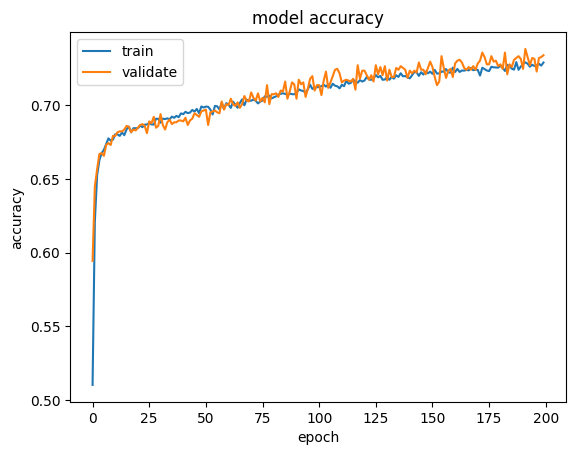

In [30]:
plt.plot(result.history['acc'])
plt.plot(result.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.savefig('img/train_validate_accuracy.png')
plt.show()

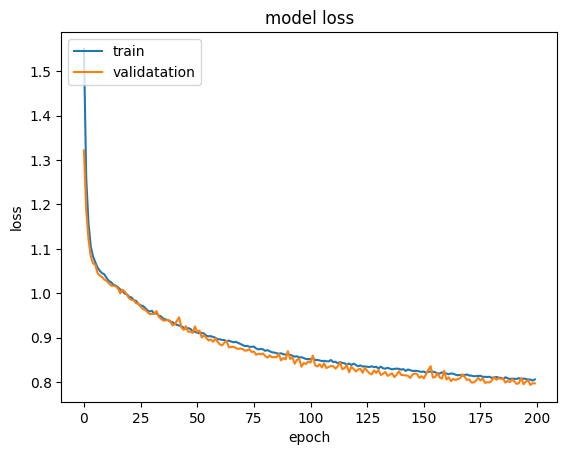

In [31]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validatation'], loc='upper left')
plt.savefig('img/train_validate_loss.png')
plt.show()

The training completes here. We save the model and load the model when test cases are invoked 

In [32]:
k = model.predict_classes(test_X)

In [33]:
print(list(set(k)))
print([list(k).count(job) for job in list(set(k))])

[0, 1, 2, 4, 6, 7, 8]
[56, 179, 400, 1317, 32, 12, 38]


In [34]:
print("The test set given by the neural network has an accuracy of ", sum(k == np.argmax(test_label, axis = 1))/len(k))

The test set given by the neural network has an accuracy of  0.7315634218289085


In [35]:
dim = nClasses
conMat = np.zeros((dim,dim))
for i in range(len(k)):
    conMat[k[i]][np.argmax(test_label, axis = 1)[i]]+=1

In [36]:
labs = np.argmax(test_label, axis = 1)
counts = [list(labs).count(lab) for lab in set(labs)]
counts

[114, 214, 360, 9, 1102, 9, 94, 47, 85]

In [148]:
conResult = pd.DataFrame(100*np.round(conMat/counts,3))
conResult.rename(index=str, columns=reverseDic)
conResult

,0,1,2,3,4,5,6,7,8
0,27.2,1.4,0.6,11.1,1.3,0.0,4.3,0.0,1.2
1,6.1,46.3,3.9,0.0,3.3,0.0,7.4,6.4,15.3
2,7.0,13.1,86.9,0.0,2.2,0.0,3.2,12.8,21.2
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,55.3,33.2,8.1,88.9,91.6,100.0,64.9,57.4,47.1
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.8,2.3,0.0,0.0,0.6,0.0,19.1,0.0,0.0
7,0.0,0.0,0.0,0.0,0.5,0.0,0.0,12.8,1.2
8,2.6,3.7,0.6,0.0,0.6,0.0,1.1,10.6,14.1


In [152]:
for i in conResult.columns:
    if conResult[i][i] < 20:
        print("deleted ", reverseDic[i])
        conResult = conResult.drop(i,axis=0)
        conResult = conResult.drop(i,axis=1)
        i -= 1

deleted  Concrete
deleted  Gypsum
deleted  Metal


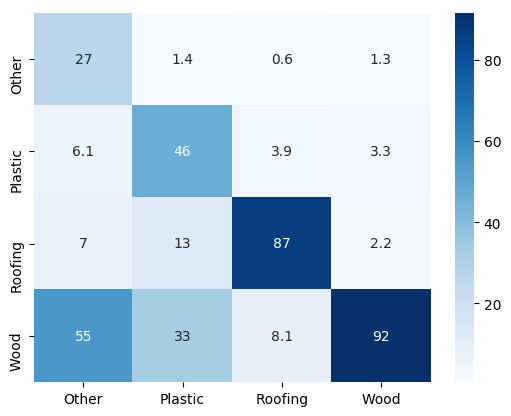

In [153]:
sns_fig = sns.heatmap(conResult,annot=True,cmap=plt.cm.Blues,xticklabels = [reverseDic[i] for i in conResult.columns], yticklabels=[reverseDic[i] for i in conResult.columns])
fig = sns_fig.get_figure()
fig.savefig("./img/Confusion.png")

['Other', 'Plastic', 'Roofing', 'Organics', 'Wood', 'Bricks', 'Concrete', 'Gypsum', 'Metal']
[114, 214, 360, 9, 1102, 9, 94, 47, 85]
['Plastic', 'Roofing', 'Wood', 'Gypsum', 'Metal']
[113, 445, 1470, 1, 5]
['Metal', 'Plastic', 'Roofing', 'Wood']
[2, 57, 290, 1023]
['Other', 'Plastic', 'Roofing', 'Organics', 'Wood', 'Bricks', 'Concrete', 'Gypsum', 'Metal']
[114, 157, 70, 9, 79, 9, 94, 47, 83]


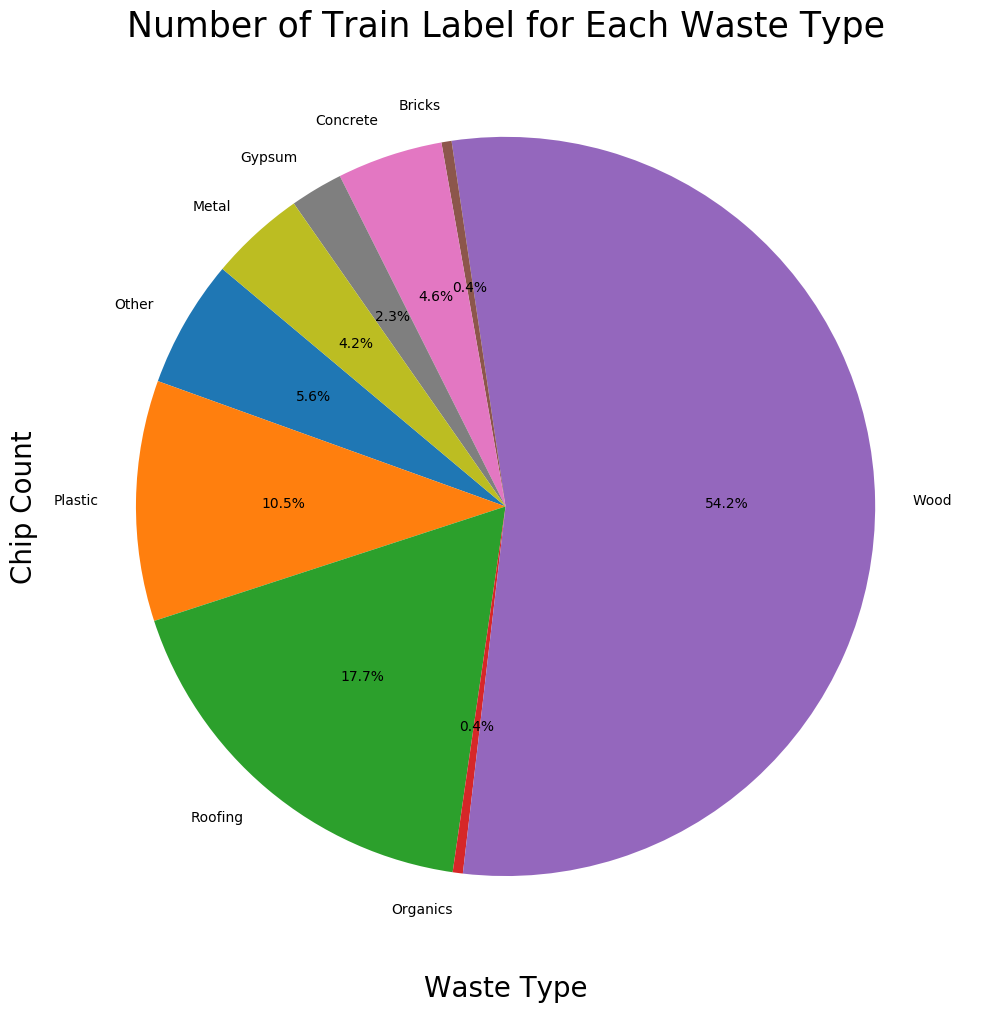

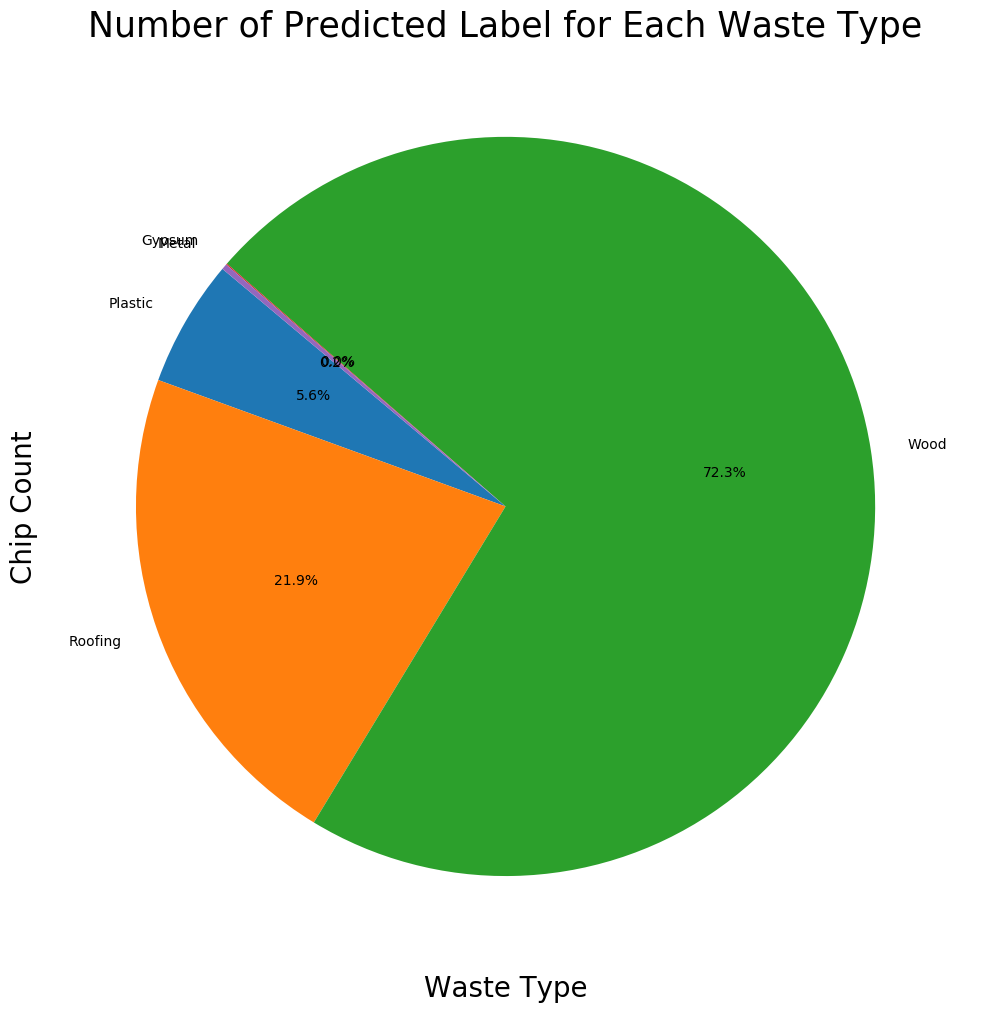

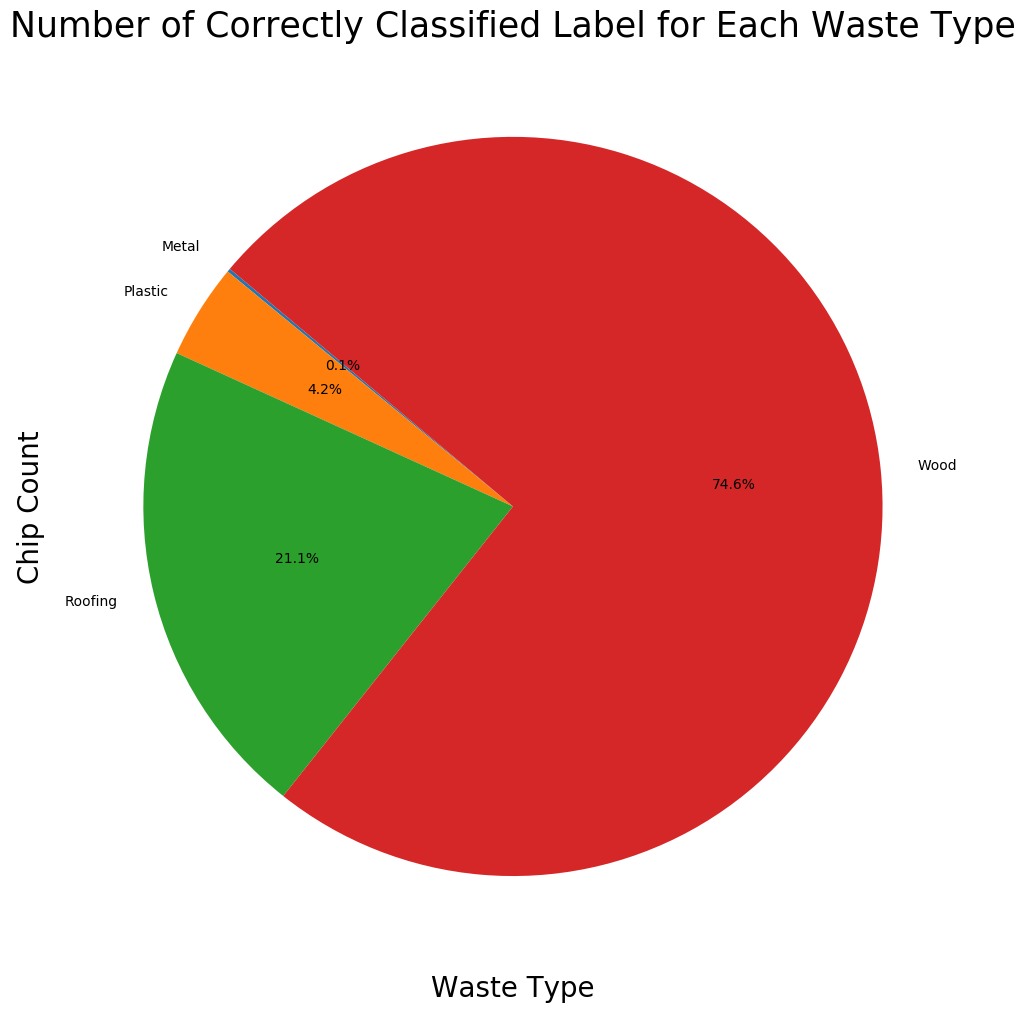

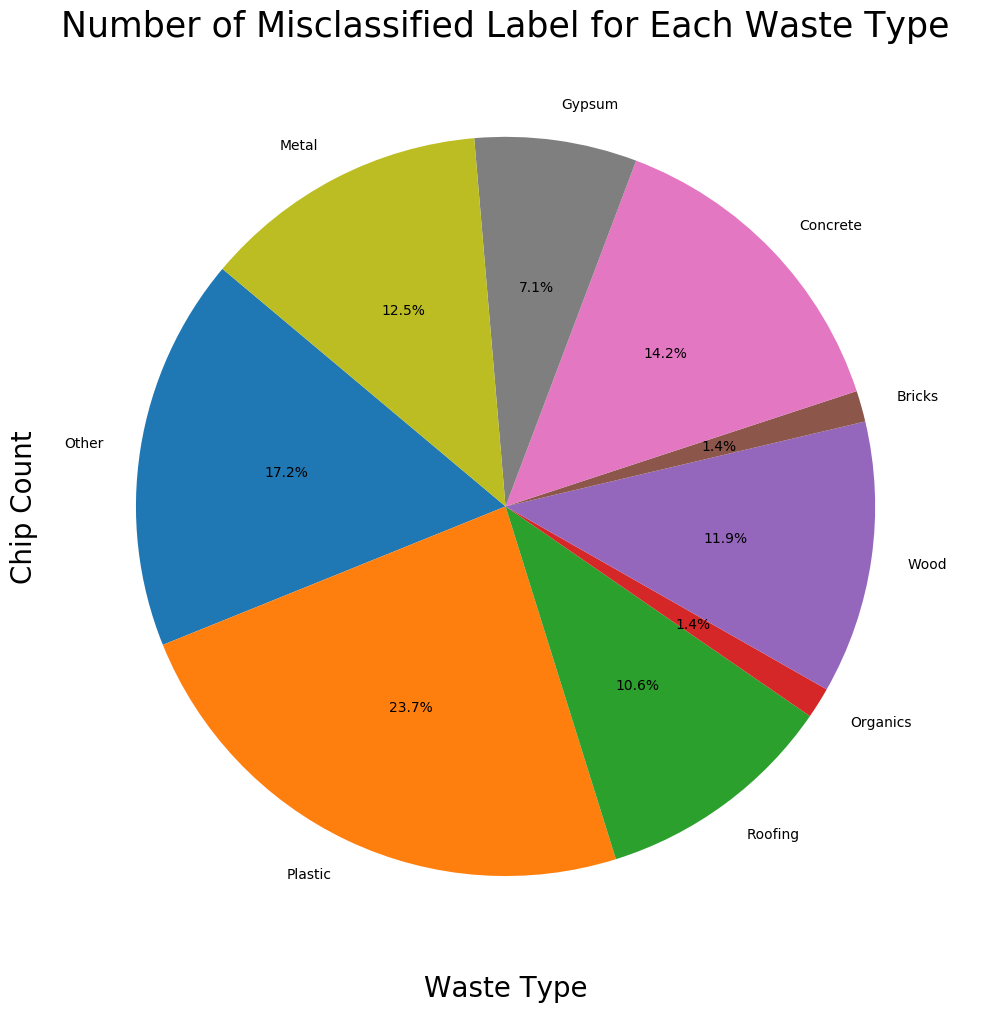

In [154]:
correct_test = list(np.argmax(test_label, axis = 1)[k  == np.argmax(test_label, axis = 1)])
incorrect_test = list(np.argmax(test_label, axis = 1)[k  != np.argmax(test_label, axis = 1)])

def drawHist(label, name):
    #test_label distribution
    test_material = [reverseDic[int(material)] for material in list(set(label))]
    print(test_material)
    test_count = [list(label).count(job) for job in list(set(label))]
    print(test_count)
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    #sns.barplot(x=test_material, y=test_count)
    plt.pie(test_count, labels=test_material, autopct='%1.1f%%', startangle=140)
    plt.xlabel('Waste Type', fontsize=20)
    plt.ylabel('Chip Count', fontsize=20)
    plt.title('Number of ' + name + ' for Each Waste Type', fontsize=25)
    name = name.replace(" ", "_")
    f.savefig("img/" + str(name) + '.png')

drawHist(np.argmax(test_label, axis=1), "Train Label")
drawHist(k, "Predicted Label")
drawHist(correct_test, "Correctly Classified Label")
drawHist(incorrect_test, "Misclassified Label")

In [86]:
(np.argmax(test_label, axis = 1) == 4).astype(int)

array([1, 1, 0, ..., 0, 1, 1])

In [92]:
(model.predict_classes(test_X) == 4).astype(int)

array([1, 1, 0, ..., 0, 1, 0])

In [138]:
classNumber = 4
from sklearn.metrics import roc_curve
y_pred_keras = (model.predict_classes(test_X) == classNumber).astype(int).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve((np.argmax(test_label, axis = 1) == classNumber).astype(int), y_pred_keras)

In [139]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras,tpr_keras)

In [140]:
auc_keras

0.7925679412383259

In [170]:
sum = 0
numTrials = 99999
for i in range(numTrials):
    if(np.linalg.norm(np.random.rand(2)) < 1):
        sum += 1
    
print("Approximated pi is: ", 4.0*sum/numTrials)

Approximated pi is:  3.145111451114511


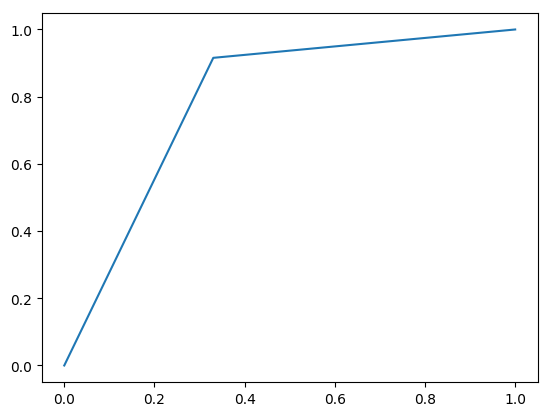

In [171]:
plt.plot(fpr_keras, tpr_keras)

In [74]:
regularization = 0.0000001
weight = np.linalg.inv(train_X.T.dot(train_X)+regularization * np.eye(features.shape[1])).dot(train_X.T).dot(train_label)
print("The weight shape is ", weight.shape)
k = np.argmax(test_X.dot(weight), axis = 1)
print(list(set(k)))
print([list(k).count(job) for job in list(set(k))])
print("The test set gives an accuracy of ", sum(k == np.argmax(test_label, axis = 1))/len(k))

The weight shape is  (31, 9)
[1, 2, 4, 7, 8]
[113, 445, 1470, 1, 5]
The test set gives an accuracy of  0.6745329400196657


In [79]:
np.linalg.norm(weight)

241.6173860003934

In [80]:
import seaborn as sns
featuresPd = pd.DataFrame(features)
featuresPd.columns = ["Red-bar","Green-bar","Blue-bar",
                      "Red lvl 1","Red lvl 2","Red lvl 3","Red lvl 4","Red lvl 5","Red lvl 6","Red lvl 7","Red lvl 8",
"Green lvl 1","Green lvl 2","Green lvl 3","Green lvl 4","Green lvl 5","Green lvl 6","Green lvl 7","Green lvl 8",
"Blue lvl 1","Blue lvl 2","Blue lvl 3","Blue lvl 4","Blue lvl 5","Blue lvl 6","Blue lvl 7","Blue lvl 8",
                     "Red FFT", "Green FFT", "Blue FFT", "index"]
featuresPd['label'] = pd.Series(np.array(y).reshape(-1,), index=featuresPd.index)
corrMat = featuresPd.corr()

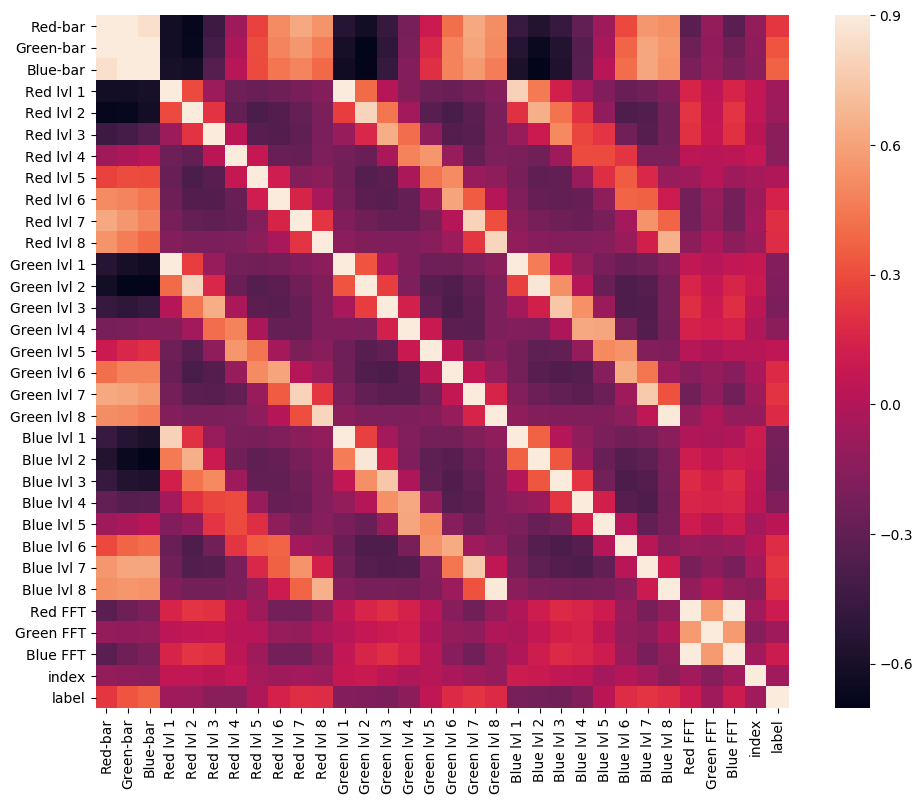

In [133]:
plt.subplots(figsize=(12,9))
corrMat = featuresPd.corr()
sns.heatmap(corrMat, vmax=0.9, square=True)
plt.savefig("img/corrMat.png")

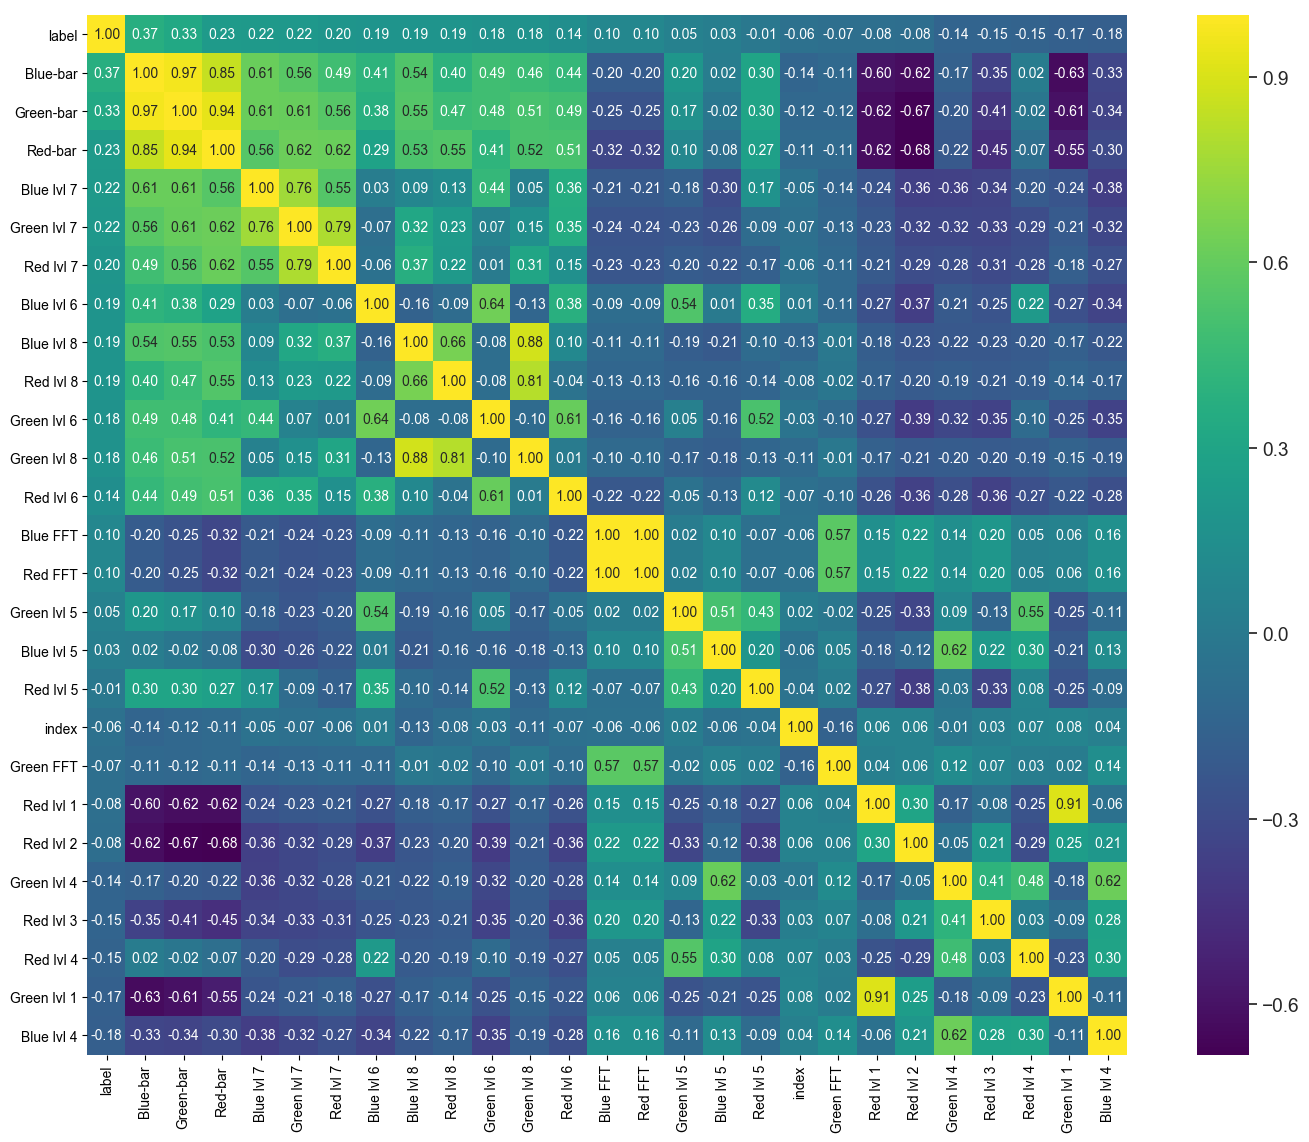

In [134]:
k = 27 #number of variables for heatmap
plt.subplots(figsize=(18,13.5))
cols = corrMat.nlargest(k, 'label')['label'].index
cm = np.corrcoef(featuresPd[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap= 'viridis',cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.savefig("img/featureMap.png")
plt.show()

In [124]:
model.save("model.h5py")